In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, 2*L
src = [0, 0]
k = 20

In [3]:
## hyperparameter
w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(1e2)
learning_rate = 2e-5

In [6]:
## Dataset

def get_dataset(Lx, Ly, src, std=0.01, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(100000, 1) - Lx, 2 * Ly * torch.rand(100000, 1) - Ly
    r, theta = torch.linspace(0, 2, 200), torch.linspace(0, 2 * np.pi, 240)
    r, theta = torch.meshgrid(r, theta)
    r, theta = r.reshape(-1, 1), theta.reshape(-1, 1)
    x, y = r * torch.cos(theta) + src[0], r * torch.sin(theta) + src[1]
    x_min, x_max = -Lx, Lx
    y_min, y_max = -Ly, Ly
    mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    x, y = x[mask].reshape(-1, 1), y[mask].reshape(-1, 1)
    x0, y0 = x[-len(r):, :], y[-len(r):, :]
    f = 1 / (2 * np.pi * std ** 2) * torch.exp(-0.5 * (((x0 - src[0])/std)**2 + ((y0 - src[1])/std)**2))
    f = torch.cat([f, torch.zeros_like(f)], dim=-1)
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
             f.to(device)

def data_iter(batch_size, x, y, f):
    import random as rd
    num = len(f)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id], f[batch_id]

In [7]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(torch.abs(y) - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), -sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), -sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, src, k, f, L_pml=0.5, sigma0=5):
    x, y = x.reshape(-1, 1).to(device), y.reshape(-1, 1).to(device)
    x, y = x.requires_grad_(), y.requires_grad_()
    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1], x, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2], x, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1], x, torch.ones_like(px[:, 0:1]), create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2], x, torch.ones_like(px[:, 1:2]), create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1], y, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2], y, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1], y, torch.ones_like(py[:, 0:1]), create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2], y, torch.ones_like(py[:, 1:2]), create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p) - f
    del pyy, pxx
    return (res ** 2).mean()

In [8]:
new_train = True
if new_train:
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.apply(sine_init)
    model.net[0].apply(first_layer_sine_init)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    l_lst = []
else:
    import joblib
    state_dict = joblib.load('model_line.joblib')
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.load_state_dict(state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    l_lst = []

In [9]:
n_epochs = int(5e2)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [10]:
x0, y0, f0 = get_dataset(Lx, Ly, src)
model = model.to(device)
for epoch in tqdm(range(n_epochs)):
    for x, y, f in data_iter(10000, x0, y0, f0):
        optimizer.zero_grad()
        loss_pde = loss_fn(model, x, y, src, k, f, L_pml=0.5, sigma0=5)
        loss = loss_pde
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0: 
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    l_lst.append(loss)

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_76520/138619739.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_76520/138619739.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
  1%|          | 5/500 [00:04<05:

Epoch 5, Loss: 475.4617614746094


  2%|▏         | 10/500 [00:07<04:58,  1.64it/s]

Epoch 10, Loss: 187.55197143554688


  3%|▎         | 15/500 [00:10<04:48,  1.68it/s]

Epoch 15, Loss: 98.64359283447266


  4%|▍         | 20/500 [00:12<04:45,  1.68it/s]

Epoch 20, Loss: 66.16622161865234


  5%|▌         | 25/500 [00:15<04:42,  1.68it/s]

Epoch 25, Loss: 52.123172760009766


  6%|▌         | 30/500 [00:18<04:39,  1.68it/s]

Epoch 30, Loss: 42.817115783691406


  7%|▋         | 35/500 [00:21<04:37,  1.68it/s]

Epoch 35, Loss: 35.01515197753906


  8%|▊         | 40/500 [00:24<04:34,  1.68it/s]

Epoch 40, Loss: 30.55218505859375


  9%|▉         | 45/500 [00:27<04:31,  1.67it/s]

Epoch 45, Loss: 26.245378494262695


 10%|█         | 50/500 [00:30<04:28,  1.67it/s]

Epoch 50, Loss: 23.472196578979492


 11%|█         | 55/500 [00:33<04:26,  1.67it/s]

Epoch 55, Loss: 20.733943939208984


 12%|█▏        | 60/500 [00:36<04:23,  1.67it/s]

Epoch 60, Loss: 18.396942138671875


 13%|█▎        | 65/500 [00:39<04:20,  1.67it/s]

Epoch 65, Loss: 16.67656707763672


 14%|█▍        | 70/500 [00:42<04:18,  1.67it/s]

Epoch 70, Loss: 15.270666122436523


 15%|█▌        | 75/500 [00:45<04:15,  1.66it/s]

Epoch 75, Loss: 13.940299987792969


 16%|█▌        | 80/500 [00:48<04:12,  1.66it/s]

Epoch 80, Loss: 12.949687004089355


 17%|█▋        | 85/500 [00:51<04:09,  1.66it/s]

Epoch 85, Loss: 11.773963928222656


 18%|█▊        | 90/500 [00:54<04:07,  1.66it/s]

Epoch 90, Loss: 10.895350456237793


 19%|█▉        | 95/500 [00:57<04:04,  1.66it/s]

Epoch 95, Loss: 10.111544609069824


 20%|██        | 100/500 [01:00<04:01,  1.66it/s]

Epoch 100, Loss: 9.585927963256836


 21%|██        | 105/500 [01:03<03:58,  1.66it/s]

Epoch 105, Loss: 8.776554107666016


 22%|██▏       | 110/500 [01:06<03:55,  1.65it/s]

Epoch 110, Loss: 8.319140434265137


 23%|██▎       | 115/500 [01:09<03:52,  1.65it/s]

Epoch 115, Loss: 7.8835039138793945


 24%|██▍       | 120/500 [01:12<03:49,  1.65it/s]

Epoch 120, Loss: 7.303741455078125


 25%|██▌       | 125/500 [01:15<03:46,  1.65it/s]

Epoch 125, Loss: 6.972261905670166


 26%|██▌       | 130/500 [01:18<03:44,  1.65it/s]

Epoch 130, Loss: 6.634795665740967


 27%|██▋       | 135/500 [01:21<03:41,  1.65it/s]

Epoch 135, Loss: 6.209753513336182


 28%|██▊       | 140/500 [01:24<03:38,  1.65it/s]

Epoch 140, Loss: 5.829727649688721


 29%|██▉       | 145/500 [01:27<03:35,  1.65it/s]

Epoch 145, Loss: 5.602736473083496


 30%|███       | 150/500 [01:30<03:32,  1.65it/s]

Epoch 150, Loss: 10.373394012451172


 31%|███       | 155/500 [01:33<03:29,  1.65it/s]

Epoch 155, Loss: 64.79581451416016


 32%|███▏      | 160/500 [01:36<03:26,  1.65it/s]

Epoch 160, Loss: 23.0539608001709


 33%|███▎      | 165/500 [01:39<03:23,  1.65it/s]

Epoch 165, Loss: 6.671357154846191


 34%|███▍      | 170/500 [01:42<03:20,  1.65it/s]

Epoch 170, Loss: 5.0093793869018555


 35%|███▌      | 175/500 [01:45<03:17,  1.65it/s]

Epoch 175, Loss: 4.669572830200195


 36%|███▌      | 180/500 [01:48<03:14,  1.65it/s]

Epoch 180, Loss: 4.469232559204102


 37%|███▋      | 185/500 [01:51<03:11,  1.65it/s]

Epoch 185, Loss: 4.604526996612549


 38%|███▊      | 190/500 [01:54<03:08,  1.65it/s]

Epoch 190, Loss: 4.525461673736572


 39%|███▉      | 195/500 [01:57<03:05,  1.65it/s]

Epoch 195, Loss: 21.310768127441406


 40%|████      | 200/500 [01:59<03:02,  1.65it/s]

Epoch 200, Loss: 5.931107997894287


 41%|████      | 205/500 [02:02<02:59,  1.65it/s]

Epoch 205, Loss: 4.574872016906738


 42%|████▏     | 210/500 [02:05<02:56,  1.65it/s]

Epoch 210, Loss: 3.9498090744018555


 43%|████▎     | 215/500 [02:08<02:53,  1.64it/s]

Epoch 215, Loss: 3.476217746734619


 44%|████▍     | 220/500 [02:11<02:50,  1.64it/s]

Epoch 220, Loss: 3.473602771759033


 45%|████▌     | 225/500 [02:14<02:47,  1.64it/s]

Epoch 225, Loss: 3.244673490524292


 46%|████▌     | 230/500 [02:17<02:44,  1.64it/s]

Epoch 230, Loss: 3.180966854095459


 47%|████▋     | 235/500 [02:20<02:41,  1.64it/s]

Epoch 235, Loss: 3.0735294818878174


 48%|████▊     | 240/500 [02:23<02:38,  1.64it/s]

Epoch 240, Loss: 2.988043785095215


 49%|████▉     | 245/500 [02:26<02:35,  1.64it/s]

Epoch 245, Loss: 2.98422908782959


 50%|█████     | 250/500 [02:29<02:32,  1.64it/s]

Epoch 250, Loss: 2.863274335861206


 51%|█████     | 255/500 [02:32<02:29,  1.64it/s]

Epoch 255, Loss: 2.731834888458252


 52%|█████▏    | 260/500 [02:35<02:26,  1.64it/s]

Epoch 260, Loss: 2.6604437828063965


 53%|█████▎    | 265/500 [02:38<02:23,  1.64it/s]

Epoch 265, Loss: 2.701788902282715


 54%|█████▍    | 270/500 [02:41<02:20,  1.64it/s]

Epoch 270, Loss: 2.585659980773926


 55%|█████▌    | 275/500 [02:44<02:17,  1.64it/s]

Epoch 275, Loss: 2.5420634746551514


 56%|█████▌    | 280/500 [02:47<02:14,  1.64it/s]

Epoch 280, Loss: 2.439537525177002


 57%|█████▋    | 285/500 [02:51<02:11,  1.64it/s]

Epoch 285, Loss: 2.3906335830688477


 58%|█████▊    | 290/500 [02:54<02:08,  1.64it/s]

Epoch 290, Loss: 2.3499350547790527


 59%|█████▉    | 295/500 [02:57<02:04,  1.64it/s]

Epoch 295, Loss: 2.2440829277038574


 60%|██████    | 300/500 [03:00<02:01,  1.64it/s]

Epoch 300, Loss: 2.264578104019165


 61%|██████    | 305/500 [03:03<01:58,  1.64it/s]

Epoch 305, Loss: 2.5554330348968506


 62%|██████▏   | 310/500 [03:06<01:55,  1.64it/s]

Epoch 310, Loss: 2.986508369445801


 63%|██████▎   | 315/500 [03:09<01:52,  1.64it/s]

Epoch 315, Loss: 4.434863090515137


 64%|██████▍   | 320/500 [03:12<01:49,  1.64it/s]

Epoch 320, Loss: 7.268199920654297


 65%|██████▌   | 325/500 [03:15<01:46,  1.64it/s]

Epoch 325, Loss: 175.6779327392578


 66%|██████▌   | 330/500 [03:18<01:43,  1.64it/s]

Epoch 330, Loss: 348.8619689941406


 67%|██████▋   | 335/500 [03:21<01:40,  1.64it/s]

Epoch 335, Loss: 26.243288040161133


 68%|██████▊   | 340/500 [03:24<01:37,  1.64it/s]

Epoch 340, Loss: 7.169622898101807


 69%|██████▉   | 345/500 [03:27<01:34,  1.64it/s]

Epoch 345, Loss: 4.158430099487305


 70%|███████   | 350/500 [03:30<01:31,  1.64it/s]

Epoch 350, Loss: 3.2425808906555176


 71%|███████   | 355/500 [03:33<01:28,  1.64it/s]

Epoch 355, Loss: 2.884145498275757


 72%|███████▏  | 360/500 [03:36<01:25,  1.64it/s]

Epoch 360, Loss: 2.5517845153808594


 73%|███████▎  | 365/500 [03:39<01:22,  1.64it/s]

Epoch 365, Loss: 2.4567930698394775


 74%|███████▍  | 370/500 [03:42<01:19,  1.64it/s]

Epoch 370, Loss: 2.3162126541137695


 75%|███████▌  | 375/500 [03:45<01:16,  1.64it/s]

Epoch 375, Loss: 2.29512882232666


 76%|███████▌  | 380/500 [03:48<01:13,  1.64it/s]

Epoch 380, Loss: 2.145817756652832


 77%|███████▋  | 385/500 [03:51<01:10,  1.64it/s]

Epoch 385, Loss: 2.083928108215332


 78%|███████▊  | 390/500 [03:54<01:07,  1.64it/s]

Epoch 390, Loss: 2.03074312210083


 79%|███████▉  | 395/500 [03:57<01:04,  1.63it/s]

Epoch 395, Loss: 2.014671564102173


 80%|████████  | 400/500 [04:00<01:01,  1.63it/s]

Epoch 400, Loss: 1.9791150093078613


 81%|████████  | 405/500 [04:03<00:58,  1.63it/s]

Epoch 405, Loss: 1.941429615020752


 82%|████████▏ | 410/500 [04:06<00:55,  1.63it/s]

Epoch 410, Loss: 1.8670457601547241


 83%|████████▎ | 415/500 [04:09<00:51,  1.64it/s]

Epoch 415, Loss: 1.825156569480896


 84%|████████▍ | 420/500 [04:12<00:48,  1.64it/s]

Epoch 420, Loss: 1.8128212690353394


 85%|████████▌ | 425/500 [04:15<00:45,  1.64it/s]

Epoch 425, Loss: 1.7734535932540894


 86%|████████▌ | 430/500 [04:18<00:42,  1.64it/s]

Epoch 430, Loss: 1.7805653810501099


 87%|████████▋ | 435/500 [04:21<00:39,  1.64it/s]

Epoch 435, Loss: 1.740583062171936


 88%|████████▊ | 440/500 [04:24<00:36,  1.64it/s]

Epoch 440, Loss: 1.6997653245925903


 89%|████████▉ | 445/500 [04:27<00:33,  1.64it/s]

Epoch 445, Loss: 1.6972085237503052


 90%|█████████ | 450/500 [04:30<00:30,  1.64it/s]

Epoch 450, Loss: 1.6561838388442993


 91%|█████████ | 455/500 [04:33<00:27,  1.64it/s]

Epoch 455, Loss: 1.6897245645523071


 92%|█████████▏| 460/500 [04:36<00:24,  1.64it/s]

Epoch 460, Loss: 1.632615327835083


 93%|█████████▎| 465/500 [04:39<00:21,  1.63it/s]

Epoch 465, Loss: 1.6259074211120605


 94%|█████████▍| 470/500 [04:42<00:18,  1.64it/s]

Epoch 470, Loss: 1.6217108964920044


 95%|█████████▌| 475/500 [04:45<00:15,  1.64it/s]

Epoch 475, Loss: 1.5516564846038818


 96%|█████████▌| 480/500 [04:48<00:12,  1.64it/s]

Epoch 480, Loss: 1.5648388862609863


 97%|█████████▋| 485/500 [04:51<00:09,  1.64it/s]

Epoch 485, Loss: 1.5648658275604248


 98%|█████████▊| 490/500 [04:54<00:06,  1.64it/s]

Epoch 490, Loss: 1.538957118988037


 99%|█████████▉| 495/500 [04:57<00:03,  1.63it/s]

Epoch 495, Loss: 1.514190912246704


100%|██████████| 500/500 [05:00<00:00,  1.66it/s]

Epoch 500, Loss: 1.4701769351959229


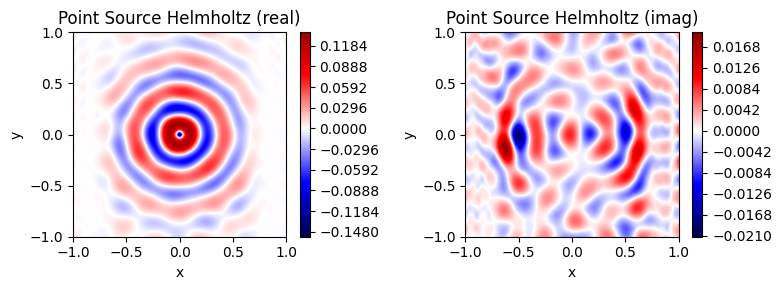

In [13]:
model_pred(model, 1, 1)

In [ ]:
import joblib
joblib.dump(model.state_dict(), 'model_line.joblib')

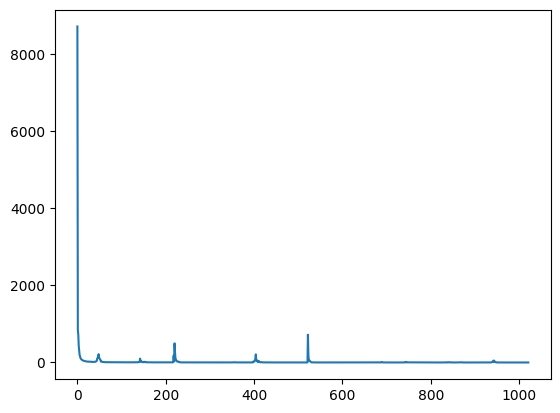

In [17]:
plot_loss(l_lst)

Error(Real) -0.007823105901479721, Error(Imag) -0.04218290001153946


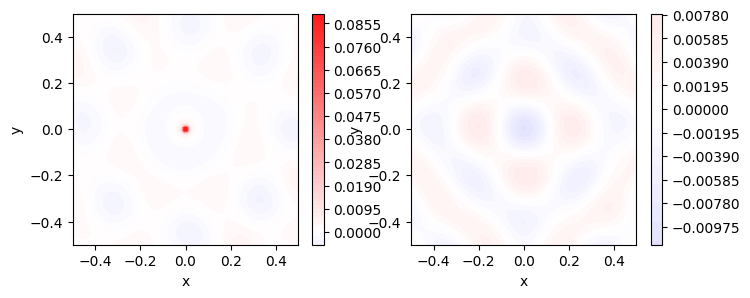

In [38]:
x, y = torch.linspace(-0.5, 0.5, N), torch.linspace(-0.5, 0.5, N)
x, y = torch.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0].detach().numpy()
p_imag = model(inputs)[:, 1].detach().numpy()
p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

x, y = x.numpy(), y.numpy()
hankel = scipy.special.hankel2(0, k * np.sqrt(x ** 2 + y ** 2) + 1e-6)
p_ref = 0.25j * hankel
p_ref_real, p_ref_imag = p_ref.real.reshape(N, N), p_ref.imag.reshape(N, N)

error_real = p_real - p_ref_real
error_imag = p_imag - p_ref_imag

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_real, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
print(f"Error(Real) {error_real.mean() / p_ref_real.mean()}, Error(Imag) {error_imag.mean() / p_ref_imag.mean()}")